# Moderation of Self-Determination on AI Acceptance

Goal:
- Test Hypothesis 2 (H2): Whether the association between Self-Determination (TENS_Life_mean) and AI acceptance for mental-health applications  (UTAUT_AI_mean) is moderated by general AI attitudes (GAAIS_mean).

Model: UTAUT_AI_mean ~ TENS_c * GAAIS_c + age_c + C(gender) + C(Country)

Key Steps:
- Load merged cross-cultural dataset
- Define H2 analysis sample
- Center continuous predictors
- Fit main-effects and interaction models
- Inspect coefficients, R², and diagnostics
- Prepare simple slopes / plot-ready data for interpretation

# 0.0 Imports and Path Setup

# 1.0 Define H2 Analysis Sample

In [31]:
df = pd.read_csv(MERGED_PATH)

print("Raw merged shape:", df.shape)
df.head()

Raw merged shape: (2342, 273)


,AI_use_sum,AIavatar_CO_mean,AIavatar_EOU_mean,AIavatar_HC_mean,AIavatar_HM_mean,AIavatar_PPR_mean,AIavatar_SE_mean,AIavatar_TQE_mean,AIavatar_mean,Accept_avatar,...,gender,jobIT,role_label,would_you_use_1,would_you_use_2,would_you_use_3,would_you_use_4,would_you_use_5,would_you_use_6,would_you_use_7
0,7.0,4.0,4.0,2.75,3.5,2.5,4.0,4.000000,3.535714,3.702381,...,3.0,1.0,therapist,NaN,1.0,NaN,1.0,NaN,1.0,1.0
1,6.0,4.0,4.0,1.75,3.5,2.0,4.0,3.333333,3.226190,3.940476,...,3.0,1.0,therapist,NaN,1.0,1.0,1.0,NaN,1.0,1.0
2,3.0,3.0,3.0,3.00,3.0,3.0,3.0,2.666667,2.952381,2.964286,...,3.0,1.0,therapist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2.0,1.5,1.50,1.0,1.0,1.0,1.000000,1.285714,2.571429,...,3.0,1.0,client,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,3.0,2.5,3.0,3.00,3.0,3.0,3.0,3.000000,2.928571,3.000000,...,3.0,1.0,client,NaN,1.0,1.0,1.0,NaN,1.0,NaN


In [5]:
# Core variables needed for H2
h2_vars = [
    "UTAUT_AI_mean",   # Outcome: global AI acceptance in mental-health interventions
    "TENS_Life_mean",  # Self-determination
    "GAAIS_mean",      # General AI attitudes
    "age",             # Covariate
    "gender",          # Covariate (categorical)
    "Country",         # Covariate (China vs USA)
]

## 1.1. Subset and listwise deletion for H2

In [7]:
h2_df = df[h2_vars].dropna().copy()
print("H2 sample shape:", h2_df.shape)

H2 sample shape: (2096, 6)


In [8]:
print("Country distribution (H2 sample):")
print(h2_df["Country"].value_counts(dropna=False))

Country distribution (H2 sample):
Country
USA      1611
China     485
Name: count, dtype: int64


In [9]:
print("Gender distribution (H2 sample):")
print(h2_df["gender"].value_counts(dropna=False))

Gender distribution (H2 sample):
gender
1.0    1120
2.0     925
3.0      44
4.0       7
Name: count, dtype: int64


In [10]:
# Basic outcome descriptives
print("Outcome (UTAUT_AI_mean) descriptives:")
print(h2_df["UTAUT_AI_mean"].describe())

Outcome (UTAUT_AI_mean) descriptives:
count    2096.000000
mean        4.794421
std         1.383634
min         1.115385
25%         3.448718
50%         5.000000
75%         6.037037
max         7.814815
Name: UTAUT_AI_mean, dtype: float64


# 2.0 Variable Centering and Preparation

In [12]:
# Create centered versions of continuous predictors
for col in ["TENS_Life_mean", "GAAIS_mean", "age"]:
    mean_val = h2_df[col].mean()
    h2_df[f"{col}_c"] = h2_df[col] - mean_val
    print(f"{col} mean for centering: {mean_val:.3f}")

TENS_Life_mean mean for centering: 4.762
GAAIS_mean mean for centering: 4.615
age mean for centering: 33.641


In [13]:
# Means of centered variables should be ~0
print("Means of centered variables (should be ≈ 0):")
print(h2_df[["TENS_Life_mean_c", "GAAIS_mean_c", "age_c"]].mean())

Means of centered variables (should be ≈ 0):
TENS_Life_mean_c    5.898590e-16
GAAIS_mean_c       -1.355998e-16
age_c               1.301758e-15
dtype: float64


# 3.0 Descriptive Plots and Correlations

In [16]:
# Pairwise correlations among key continuous predictors
cont_cols = ["UTAUT_AI_mean", "TENS_Life_mean", "GAAIS_mean", "age"]
corr = h2_df[cont_cols].corr()

print("Correlation matrix:")
print(corr.round(3))

Correlation matrix:
                UTAUT_AI_mean  TENS_Life_mean  GAAIS_mean    age
UTAUT_AI_mean           1.000           0.160       0.125  0.171
TENS_Life_mean          0.160           1.000       0.229  0.213
GAAIS_mean              0.125           0.229       1.000  0.109
age                     0.171           0.213       0.109  1.000


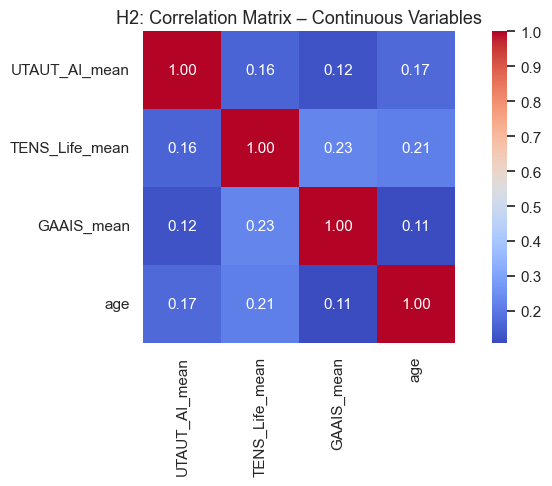

In [17]:
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("H2: Correlation Matrix – Continuous Variables")
plt.tight_layout()
plt.show()

# 4.0 Baseline Model (Main Effect)

In [19]:
# Baseline model: main effects only (no interaction)
formula_h2_main = (
    "UTAUT_AI_mean ~ TENS_Life_mean_c + GAAIS_mean_c "
    "+ age_c + C(gender) + C(Country)"
)

h2_main_model = smf.ols(formula=formula_h2_main, data=h2_df).fit()

print("H2 Baseline (main effects only) model summary:")
h2_main_model.summary()

H2 Baseline (main effects only) model summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     110.7
Date:                Sun, 30 Nov 2025   Prob (F-statistic):          3.61e-138
Time:                        13:18:46   Log-Likelihood:                -3323.5
No. Observations:                2096   AIC:                             6663.
Df Residuals:                    2088   BIC:                             6708.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.2046      0.075     42.789      0.000       3.058       3.351
C(gender)[T.2.0]     -0.0726      0.054     -1.355      0.176      -0.178       0.032
C(gender)[T.3.0]      0.1261      0.183      0.689      0.491      -0.233       0.485
C(gender)[T.4.0]      0.5070      0.449      1.129      0.259      -0.374       1.388
C(Country)[T.USA]     2.1045      0.085     24.684      0.000       1.937       2.272
TENS_Life_mean_c      0.0641      0.027      2.382      0.017       0.011       0.117
GAAIS_mean_c          0.2240      0.034      6.595      0.000       0.157       0.291
age_c                -0.0238      0.002    -11.280      0.000      -0.028      -0.020
==============================================================================
Omnibus:                      165.589   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.724
Skew:                          -0.413   Prob(JB):                     4.94e-23
Kurtosis:                       2.297   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 7.0. Full H2 Model with Interaction (TENS X GAAIS)

In [20]:
# Full H2 model with interaction term
formula_h2_full = (
    "UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c "
    "+ age_c + C(gender) + C(Country)"
)

h2_full_model = smf.ols(formula=formula_h2_full, data=h2_df).fit()

print("H2 Full model (with interaction) summary:")
display(h2_full_model.summary())

H2 Full model (with interaction) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     97.21
Date:                Sun, 30 Nov 2025   Prob (F-statistic):          1.13e-137
Time:                        13:19:31   Log-Likelihood:                -3322.3
No. Observations:                2096   AIC:                             6663.
Df Residuals:                    2087   BIC:                             6713.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.2094      0.075     42.834      0.000       3.062       3.356
C(gender)[T.2.0]                 -0.0765      0.054     -1.427      0.154      -0.182       0.029
C(gender)[T.3.0]                  0.1187      0.183      0.649      0.516      -0.240       0.477
C(gender)[T.4.0]                  0.5270      0.449      1.173      0.241      -0.354       1.408
C(Country)[T.USA]                 2.0886      0.086     24.341      0.000       1.920       2.257
TENS_Life_mean_c                  0.0589      0.027      2.171      0.030       0.006       0.112
GAAIS_mean_c                      0.2222      0.034      6.542      0.000       0.156       0.289
TENS_Life_mean_c:GAAIS_mean_c     0.0494      0.031      1.590      0.112      -0.012       0.110
age_c                            -0.0239      0.002    -11.344      0.000      -0.028      -0.020
==============================================================================
Omnibus:                      166.070   Durbin-Watson:                   1.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.998
Skew:                          -0.418   Prob(JB):                     2.61e-23
Kurtosis:                       2.299   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 7.1. Extract Key Composite

In [21]:
print("Key H2 coefficients:")
print(
    h2_full_model.params[[
        "TENS_Life_mean_c",
        "GAAIS_mean_c",
        "TENS_Life_mean_c:GAAIS_mean_c"
    ]]
)

Key H2 coefficients:
TENS_Life_mean_c                 0.058881
GAAIS_mean_c                     0.222201
TENS_Life_mean_c:GAAIS_mean_c    0.049417
dtype: float64


In [22]:
print("Key H2 p-values:")
print(
    h2_full_model.pvalues[[
        "TENS_Life_mean_c",
        "GAAIS_mean_c",
        "TENS_Life_mean_c:GAAIS_mean_c"
    ]]
)

Key H2 p-values:
TENS_Life_mean_c                 3.002562e-02
GAAIS_mean_c                     7.636445e-11
TENS_Life_mean_c:GAAIS_mean_c    1.120274e-01
dtype: float64


In [23]:
print(f"R² (full H2 model) = {h2_full_model.rsquared:.3f}")

R² (full H2 model) = 0.271


In [24]:
print(f"Adj. R² (full H2 model) = {h2_full_model.rsquared_adj:.3f}")

Adj. R² (full H2 model) = 0.269


# 8.0. Model Comparison: Main Effects VS Interaction

In [26]:
print("ANOVA comparison: main-effects vs interaction model (H2)")
anova_results = anova_lm(h2_main_model, h2_full_model)
display(anova_results)

ANOVA comparison: main-effects vs interaction model (H2)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2088.0,2925.521809,0.0,NaN,NaN,NaN
1,2087.0,2921.983060,1.0,3.538749,2.52752,0.112027


# 9.0. Multicollinearity Check
- Build design matrix for VIF (excluding intercept)
- Use the same structure as the full H2 model

In [27]:
X = h2_full_model.model.exog
vif_data = []

for i, name in enumerate(h2_full_model.model.exog_names):
    if name == "Intercept":
        continue
    vif = variance_inflation_factor(X, i)
    vif_data.append({"variable": name, "VIF": vif})

vif_df = pd.DataFrame(vif_data).sort_values("VIF", ascending=False)

print("Variance Inflation Factors (H2 full model):")
display(vif_df)

Variance Inflation Factors (H2 full model):


,variable,VIF
3,C(Country)[T.USA],1.960422
7,age_c,1.938471
4,TENS_Life_mean_c,1.152632
5,GAAIS_mean_c,1.091675
6,TENS_Life_mean_c:GAAIS_mean_c,1.078788
0,C(gender)[T.2.0],1.060304
1,C(gender)[T.3.0],1.029584
2,C(gender)[T.4.0],1.005516


# 10.0. Residual Diagnostics (for Completeness)

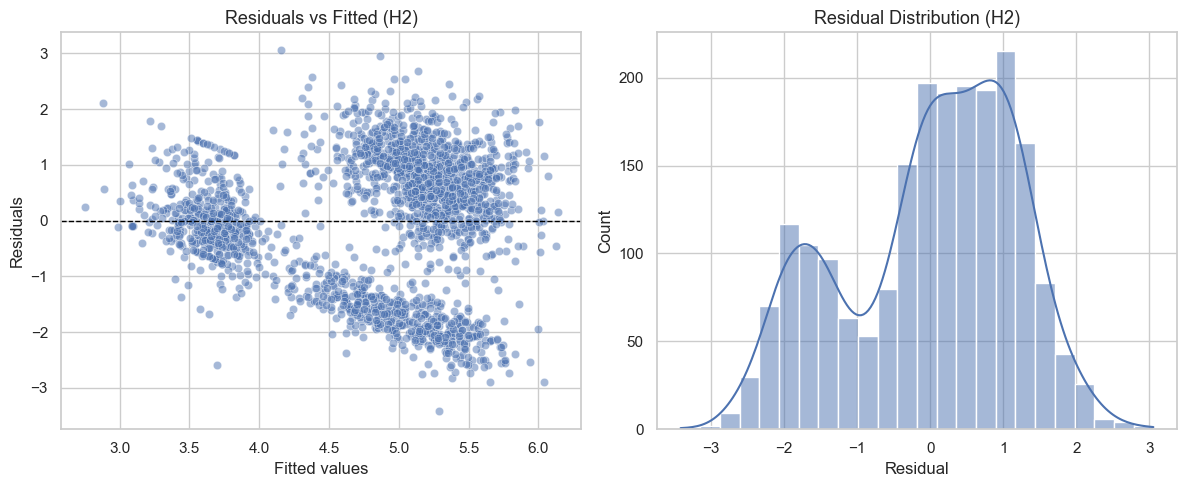

In [28]:
# Standardized residuals and fitted values
h2_df["resid"] = h2_full_model.resid
h2_df["fitted"] = h2_full_model.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs fitted
sns.scatterplot(x="fitted", y="resid", data=h2_df, ax=axes[0], alpha=0.5)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted (H2)")

# Histogram / density of residuals
sns.histplot(h2_df["resid"], kde=True, ax=axes[1])
axes[1].set_title("Residual Distribution (H2)")
axes[1].set_xlabel("Residual")

plt.tight_layout()
plt.show()

# 11.0. Simple Slopes / Plot-Ready Data (High vs Low GAAIS)

In [29]:
# Create +/- 1 SD values of moderator for probing
g_mean = h2_df["GAAIS_mean_c"].mean()
g_sd = h2_df["GAAIS_mean_c"].std()

g_levels = {
    "low_GAAIS": g_mean - g_sd,
    "mean_GAAIS": g_mean,
    "high_GAAIS": g_mean + g_sd,
}

# Range of TENS values for plotting simple slopes
tens_grid = np.linspace(
    h2_df["TENS_Life_mean_c"].min(),
    h2_df["TENS_Life_mean_c"].max(),
    50
)

pred_rows = []

for level_name, g_val in g_levels.items():
    for t_val in tens_grid:
        # Build a "typical" profile: mean age, reference category for gender and country
        row = {
            "TENS_Life_mean_c": t_val,
            "GAAIS_mean_c": g_val,
            "age_c": 0.0,             # mean-centered
            "gender": h2_df["gender"].mode()[0],
            "Country": h2_df["Country"].mode()[0],
        }
        pred_rows.append({**row, "GAAIS_level": level_name})

pred_df = pd.DataFrame(pred_rows)

# Use the fitted model to get predictions
pred_df["UTAUT_pred"] = h2_full_model.predict(pred_df)

pred_df.head()

,TENS_Life_mean_c,GAAIS_mean_c,age_c,gender,Country,GAAIS_level,UTAUT_pred
0,-3.761954,-0.79518,0.0,1.0,USA,low_GAAIS,5.047645
1,-3.639505,-0.79518,0.0,1.0,USA,low_GAAIS,5.050043
2,-3.517056,-0.79518,0.0,1.0,USA,low_GAAIS,5.052441
3,-3.394607,-0.79518,0.0,1.0,USA,low_GAAIS,5.054839
4,-3.272158,-0.79518,0.0,1.0,USA,low_GAAIS,5.057237


# 12.0. Plotting the (Non-Significant) Interaction for Visualization

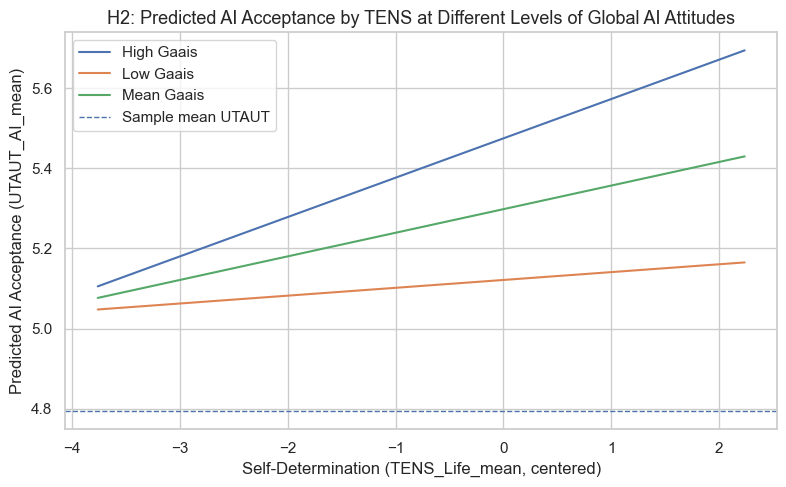

In [30]:
plt.figure(figsize=(8, 5))

for level_name, group in pred_df.groupby("GAAIS_level"):
    sns.lineplot(
        x="TENS_Life_mean_c",
        y="UTAUT_pred",
        data=group,
        label=level_name.replace("_", " ").title(),
    )

plt.axhline(h2_df["UTAUT_AI_mean"].mean(), linestyle="--", linewidth=1, label="Sample mean UTAUT")
plt.xlabel("Self-Determination (TENS_Life_mean, centered)")
plt.ylabel("Predicted AI Acceptance (UTAUT_AI_mean)")
plt.title("H2: Predicted AI Acceptance by TENS at Different Levels of Global AI Attitudes")
plt.legend()
plt.tight_layout()
plt.show()
